# Sphere Reconstruction experiment with patches generating process (diversity condition holds)

g - patching the sphere


In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..'))

import torch

from data.generation import Patches
from visualization_utils.spheres import visualize_spheres_side_by_side, scatter3d_sphere
from encoders import SphericalEncoder

from encoders import get_mlp

import matplotlib.pyplot as plt
from simclr.simclr import SimCLR
from spaces import NSphereSpace

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using', device)

Using cuda


/home/justinas/CLTheory/experiments/../sampling/sphere_sampling.py:20: SyntaxWarning: invalid escape sequence '\i'
  distribution around center mu \in R^N with concentration kappa.
/home/justinas/CLTheory/experiments/../sampling/sphere_sampling.py:50: SyntaxWarning: invalid escape sequence '\i'
  distribution around center mu \in R^N with concentration kappa.


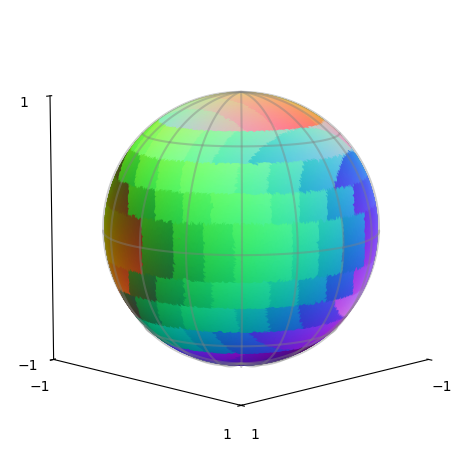

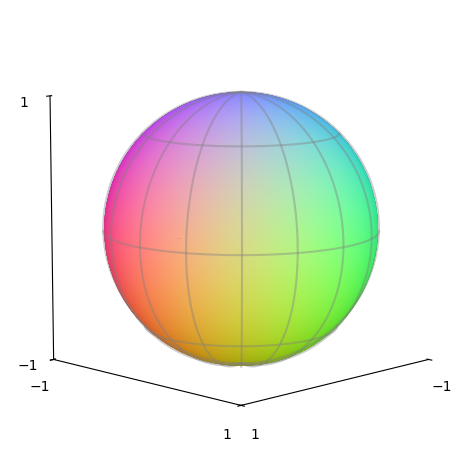

In [2]:
g_patches = Patches(5, device)

tau = 0.3
kappa = 1 / tau

iterations = 10000
batch = 6144

sphere = NSphereSpace(3)

sample_pair_fixed = lambda batch: sphere.sample_pair_vmf(batch, kappa)
sample_uniform_fixed = lambda batch: sphere.uniform(batch)

f = SphericalEncoder(hidden_dims=[128, 256, 256, 256, 256, 256, 256, 128])

h = lambda z: f(g_patches(z))

z = sphere.uniform(100000)

fig = scatter3d_sphere(plt, z.cpu(), g_patches(z.to(device)).cpu(), s=10, a=.8)
fig = scatter3d_sphere(plt, z.cpu(), z.cpu(), s=10, a=.8)

Linear control score: 1.0
Permutation control score: 1.0
Loss: 8.667144775390625 Samples processed: 1 linear disentanglement: 0.5281253457069397 permutation disentanglement: 0.07218769937753677 angle_preservation_error: 0.20619532465934753
Loss: 7.897710800170898 Samples processed: 21 linear disentanglement: 0.9653347134590149 permutation disentanglement: 0.27823200821876526 angle_preservation_error: 0.054621074348688126
Loss: 7.874238014221191 Samples processed: 41 linear disentanglement: 0.9744376540184021 permutation disentanglement: 0.2779991924762726 angle_preservation_error: 0.046042073518037796
Loss: 7.873010158538818 Samples processed: 61 linear disentanglement: 0.9762995839118958 permutation disentanglement: 0.28973469138145447 angle_preservation_error: 0.043492987751960754
Loss: 7.863750457763672 Samples processed: 81 linear disentanglement: 0.9784724116325378 permutation disentanglement: 0.28913649916648865 angle_preservation_error: 0.04137431085109711
Loss: 7.87070608139038

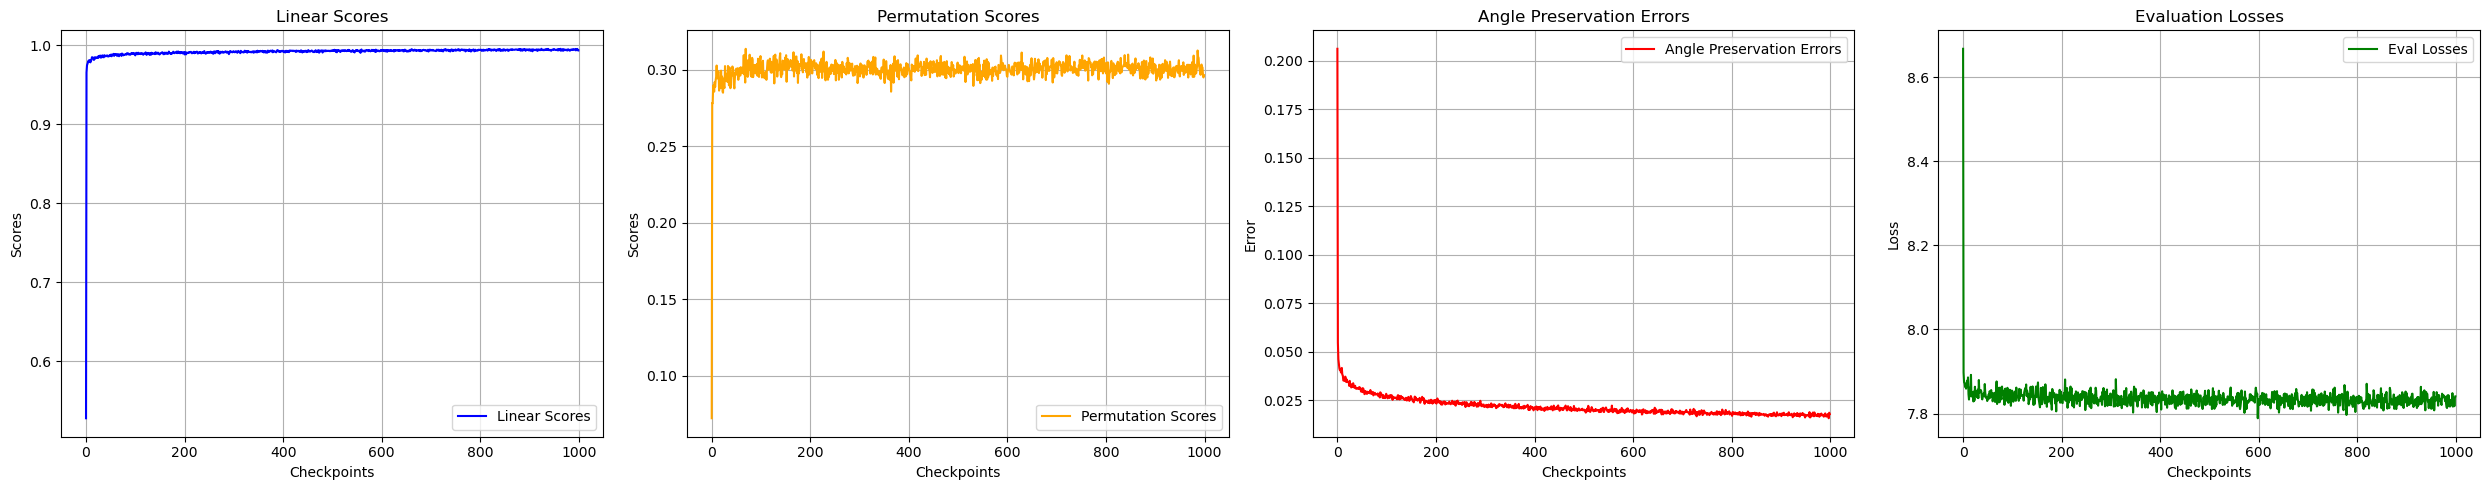

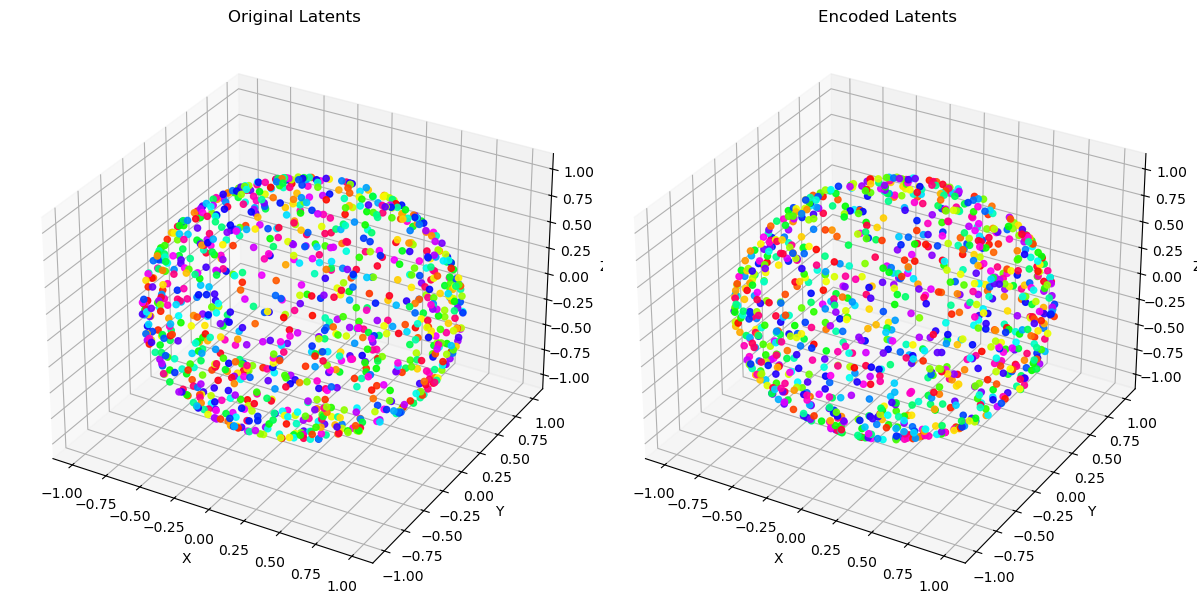

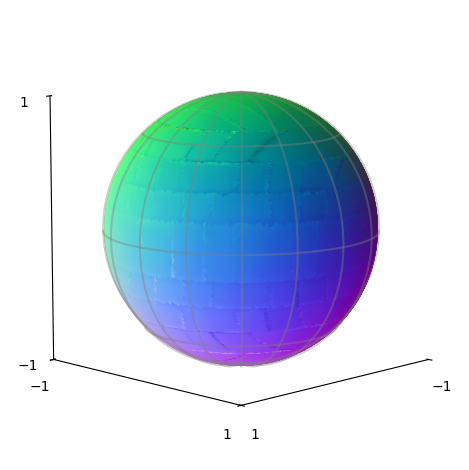

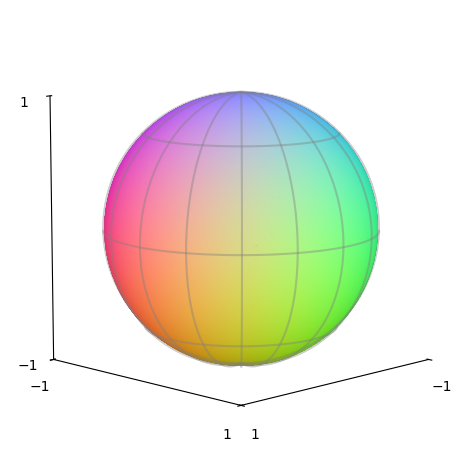

In [3]:
from visualization_utils.scoring import plot_scores

f = SphericalEncoder(hidden_dims=[256, 512, 1024, 1024, 1024, 1024, 512, 256])

iterations = 20000

simclr_vmf = SimCLR(
    f, g_patches, sample_pair_fixed, sample_uniform_fixed, tau, device
)

f, scores = simclr_vmf.train(batch, iterations)

h = lambda z: f(g_patches(z))

z = sphere.uniform(1000).to(device)
z_enc = h(z).to(device)

plot_scores(plt, scores)
visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

z = sphere.uniform(100000).to(device)

fig = scatter3d_sphere(plt, z.cpu(), h(z.to(device)).cpu(), s=10, a=.8)
fig = scatter3d_sphere(plt, z.cpu(), z.cpu(), s=10, a=.8)